# Part 1: Data Ingestion


In this notebook we will learn how to **Ingest** different data sources to our **Feature Store**.

We will ingest four different Feature Sets:
- **Transactions**: Monetary transactions between a source and a target.
- **Events**: Account events such as account login or a password change.
- **Parties**: Consumer categories of the transactions made.
- **Label**: Fraud label for the data.

We will walk through creation of ingestion pipeline for each datasource with all the needed preprocessing and validation. We will run the pipeline locally within the notebook and then launch a real-time function to **ingest live data** or schedule a cron to run the task when needed.

## Environment Setup

Since our work is done in a this project scope, first we define the project itself for all our MLRun work in this notebook.

In [1]:
import mlrun
import os

mlrun.set_environment(project='fraud-demo', user_project=True)

# location of the output data files
data_path = os.path.abspath('data/')

We also include an helper function for the demo to adjust the data's date ranges to be relative to now.

In [2]:
# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    return df

## Create Ingestion pipelines With MLRun
In this section we will ingest the lab measurements data using MLRun and Storey. Storey is the underlying implementation of the feature store which is used by MLRun. It is the engine that allows you to define and execute complex graphs that create the feature engineering pipeline. With storey, you can define source, transformations and targets, many actions are available as part of the Storey library, but you can define additional actions easily. We will see these custom actions in later sections.

For the execution, it is possible to also use Spark. The main difference between Storey and Spark pipelines is that Storey blocks are built for Real-Time workloads while Spark is more Batch oriented.  

Lets start by loading the first dataset from our publicly available csv.
This dataset contains all the transactions between the available sources and targets. Including data about the transaction categories, the device it was made by and a fraud lablel for our supervised learning algorithm.

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Sample 100k lines
data = data.sample(50000)

# Align the samples timestamp for the past 2 days
# so we can see that latest aggregations in 
# our online feature vectors
data = adjust_data_timespan(data)

data.head()

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
83182,30,3,F,28007,28007,es_transportation,30.31,0,2021-06-20 05:39:53.747545060,C1692967183,M348934600,b1bd822d1b444a968699e23f0753ff91
452978,141,3,M,28007,28007,es_transportation,4.79,0,2021-06-19 19:18:35.512191783,C1971153898,M1823072687,123acbbb73b3424d98981e6b01ec873b
189840,65,4,M,28007,28007,es_transportation,20.78,0,2021-06-18 21:55:08.332585748,C85142763,M348934600,5a684d1743014b1bb9da61998e128f95
64509,24,4,F,28007,28007,es_transportation,5.61,0,2021-06-20 12:43:25.312538615,C2014169866,M1823072687,15b7e1934169471ba41d2c57d0e15e4e
306906,100,3,M,28007,28007,es_transportation,55.84,0,2021-06-18 22:38:20.288612236,C1846578588,M348934600,4564d0a3fc9f43d7853bcd9876e0ffa5


### Define the Transactions Set

We are now going to define the first `FeatureSet` - "transactions".
This feature set should handle all the transaction related featuers and will include a custom date extraction step and multiple aggregations over the latest transaction amounts.

Lets start by importing our feature store and storey:

In [4]:
# Import MLRun's Feature Store
import mlrun.feature_store as fs
import storey

We can now define our custom transformation steps.
Here we define a custom class `DateExtractor` which will create a new feature with the wanted date parts from the specified timestamp column.

This class is created from the `storey.MapClass` base class which is intended to run the `do()` function as part of the feature set graph.

In [5]:
# nuclio: start-code

In [6]:
from typing import List, Dict, Union
import storey

class DateExtractor(storey.MapClass):
    """Date Extractor allows you to extract a date-time component
        from a timestamp feature to a new feature.

        The extracted date part will appear as `<timestamp_col>_<date_part>` feature.

        Parameters
        ----------
        parts : Union[Dict[str, str], List[str]]
            The pandas style date-time parts you want to extract.

            Supports:
            asm8                    Return numpy datetime64 format in nanoseconds.
            day_of_week             Return day of the week.
            day_of_year             Return the day of the year.
            dayofweek               Return day of the week.
            dayofyear               Return the day of the year.
            days_in_month           Return the number of days in the month.
            daysinmonth             Return the number of days in the month.
            freqstr                 Return the total number of days in the month.
            is_leap_year            Return True if year is a leap year.
            is_month_end            Return True if date is last day of month.
            is_month_start          Return True if date is first day of month.
            is_quarter_end          Return True if date is last day of the quarter.
            is_quarter_start        Return True if date is first day of the quarter.
            is_year_end             Return True if date is last day of the year.
            is_year_start           Return True if date is first day of the year.
            quarter                 Return the quarter of the year.
            tz                      Alias for tzinfo.
            week                    Return the week number of the year.
            weekofyear              Return the week number of the year.

        timestamp_col : str, optional
            The name of the column containing the timestamps to extract from,
            by default "timestamp"

        Examples
        --------
        (taken from the fraud-detection end-to-end feature store demo)
        ```
        # Define the Transactions FeatureSet
        transaction_set = fs.FeatureSet("transactions",
                                        entities=[fs.Entity("source")],
                                        timestamp_key='timestamp',
                                        description="transactions feature set")

        # Get FeatureSet computation graph
        transaction_graph = transaction_set.graph

        # Add the custom `DateExtractor` step
        # to the computation graph
        transaction_graph\
            .to(
                class_name='DateExtractor',
                name='Extract Dates',
                parts = ['hour', 'day_of_week'],
                timestamp_col = 'timestamp',
            )
        ```
        """

    def __init__(
        self, parts: List[str], timestamp_col: str = None, **kwargs,
    ):
        super().__init__(**kwargs)
        self.timestamp_col = timestamp_col
        self.parts = parts

    def _get_key_name(self, part: str, timestamp_col: str):
        timestamp_col = timestamp_col if timestamp_col else "timestamp"
        return f"{timestamp_col}_{part}"

    def do(self, event):
        # Extract timestamp
        if self.timestamp_col is None:
            timestamp = event["timestamp"]
        else:
            try:
                timestamp = event[self.timestamp_col]
            except Exception:
                raise ValueError(f"{self.timestamp_col} does not exist in the event")

        # Extract specified parts
        for part in self.parts:
            # Extract part
            extracted_part = getattr(timestamp, part)
            # Add to event
            event[self._get_key_name(part, self.timestamp_col)] = extracted_part
        return event

In [7]:
# nuclio: end-code

Now that we have the custom functions ready, we can define the `transactions` FeatureSet.

We will define the FeatureSet definition, add our custom function to the pipeline and finally add the aggregations.
The feature store will automatically add an offline `parquet` target and an online `nosql` target by using `set_targets()`.

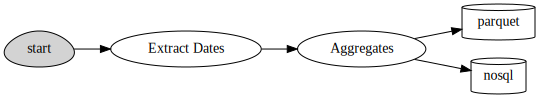

In [8]:
# Define the Transactions FeatureSet
transaction_set = fs.FeatureSet("transactions", 
                                 entities=[fs.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

# Get FeatureSet computation graph
transaction_graph = transaction_set.graph

# Add the custom `DateExtractor` step 
# to the computation graph
transaction_graph\
    .to(
        class_name='DateExtractor', 
        name='Extract Dates', 
        parts = ['hour', 'day_of_week'],
        timestamp_col = 'timestamp',
    )

# Add multiple aggregations on multiple time windows
windows = ['2h', '12h', '24h']
transaction_set.add_aggregation(name=f'amount',
                                column='amount',
                                operations=['avg','sum', 'count','max'],
                                windows=windows,
                                period='1h')

# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# User our loaded DF as the datasource and ingest it through
# the define pipeline
resp = fs.ingest(transaction_set, data, 
                 infer_options=fs.InferOptions.default())

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

Now that we ingested our data through the feature set, we can view the transformed data:

In [9]:
resp.head()

,amount_count_2h,amount_count_12h,amount_count_24h,amount_max_2h,amount_max_12h,amount_max_24h,amount_sum_2h,amount_sum_12h,amount_sum_24h,amount_avg_2h,...,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,target,device,timestamp_hour,timestamp_day_of_week
source,,,,,,,,,,,,,,,,,,,,,
C1692967183,1.0,5.0,11.0,30.31,37.93,37.93,30.31,114.90,257.88,30.31,...,28007,28007,es_transportation,30.31,0,2021-06-20 05:39:53.747545060,M348934600,b1bd822d1b444a968699e23f0753ff91,5,6
C1971153898,3.0,7.0,13.0,34.56,45.13,48.93,69.30,145.62,332.72,23.10,...,28007,28007,es_transportation,4.79,0,2021-06-19 19:18:35.512191783,M1823072687,123acbbb73b3424d98981e6b01ec873b,19,5
C85142763,1.0,1.0,1.0,20.78,20.78,20.78,20.78,20.78,20.78,20.78,...,28007,28007,es_transportation,20.78,0,2021-06-18 21:55:08.332585748,M348934600,5a684d1743014b1bb9da61998e128f95,21,4
C2014169866,1.0,5.0,13.0,5.61,37.22,65.85,5.61,86.89,305.01,5.61,...,28007,28007,es_transportation,5.61,0,2021-06-20 12:43:25.312538615,M1823072687,15b7e1934169471ba41d2c57d0e15e4e,12,6
C1846578588,1.0,1.0,1.0,55.84,55.84,55.84,55.84,55.84,55.84,55.84,...,28007,28007,es_transportation,55.84,0,2021-06-18 22:38:20.288612236,M348934600,4564d0a3fc9f43d7853bcd9876e0ffa5,22,4


### Deploy transactions feature set live endpoint

In [10]:
# Define the HTTP Source to enable the HTTP trigger on our function and expose the endpoint.
# as any other datasource, we will define the `key` and `time` fields here too.
http_source = mlrun.datastore.sources.HttpSource(key_field='source', time_field='timestamp')

# Create a `serving` "base function" to deploy the ingestion function on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function('ingest_transactions', kind='serving', image='mlrun/mlrun')
run_config = fs.RunConfig(function=function, local=False).apply(mlrun.auto_mount())

# Deploy the transactions feature set's ingestion service using the feature set
# and all the defined resources above.
transaction_set_endpoint = fs.deploy_ingestion_service(featureset=transaction_set,
                                                   source=http_source,
                                                   run_config=run_config)

> 2021-06-20 13:11:00,928 [info] Starting remote function deploy
2021-06-20 13:11:01  (info) Deploying function
{'level': 'info', 'message': 'Deploying function', 'name': 'fraud-demo-orz-ingest-transactions', 'time': 1624194661017.402}
2021-06-20 13:11:01  (info) Building
{'level': 'info', 'message': 'Building', 'name': 'fraud-demo-orz-ingest-transactions', 'time': 1624194661017.4387, 'versionInfo': 'Label: 1.5.16, Git commit: ae43a6a560c2bec42d7ccfdf6e8e11a1e3cc3774, OS: linux, Arch: amd64, Go version: go1.14.3'}
2021-06-20 13:11:01  (info) Staging files and preparing base images
{'level': 'info', 'message': 'Staging files and preparing base images', 'name': 'deployer', 'time': 1624194661087.1252}
2021-06-20 13:11:01  (info) Building processor image
{'imageName': 'nuclio/fraud-demo-orz-fraud-demo-orz-ingest-transactions-processor:latest', 'level': 'info', 'message': 'Building processor image', 'name': 'deployer', 'time': 1624194661504.1628}
2021-06-20 13:11:03  (info) Build complete
{

### Test the feature set endpoint with a sample

By defining our `transactions` feature set we can now use MLRun and Storey to deploy it as a live endpoint, ready to ingest new data!

Using MLRun's `serving` runtime, we will create a nuclio function loaded with our feature set's computational graph definition and an `HttpSource` to define the HTTP trigger.

In [11]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
sample = data.sample(1)
sample = json.loads(sample.to_json(orient='records'))[0]
sample['timestamp'] = '2021-06-11 22:07:58'
sample

{'step': 108,
 'age': '2',
 'gender': 'M',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_food',
 'amount': 17.83,
 'fraud': 0,
 'timestamp': '2021-06-11 22:07:58',
 'source': 'C1592279480',
 'target': 'M85975013',
 'device': 'ef9be3e859ec41b59313075b1a357d06'}

In [12]:
# Post the sample to the ingestion endpoint
requests.post(transaction_set_endpoint, json=sample).text

'{"id": "1a204c14-c6d1-4d34-ad9f-a4c7945d5db6"}'

### Load and define the Events Set

We will now handle our `events` feature set.
This feature set will contain all the user events related to the platform such as account logins, details or password change.

The first step will be to load our publicly available dataset:

In [13]:
# Load the events dataset
events = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Align the samples timestamp for the past 2 days
# so we can see that latest aggregations in 
# our online feature vectors
events = adjust_data_timespan(events)
events.head()

,source,event,timestamp
0,C1974668487,details_change,2021-06-19 22:18:16.937026086
1,C1973547259,login,2021-06-20 01:19:51.194166508
2,C515668508,login,2021-06-19 21:52:57.475343302
3,C1721541488,details_change,2021-06-20 00:00:27.584560221
4,C394979408,password_change,2021-06-20 01:38:15.631983667


Now we will define the events feature set.
This is a pretty straight forward pipeline in which we only one hot encode the event categories and save the data to the default targets.

In [14]:
from mlrun.feature_store.steps import OneHotEncoder

events_set = fs.FeatureSet("events",
                           entities=[fs.Entity("source")],
                           timestamp_key='timestamp', 
                           description="events feature set")
events_set_graph = events_set.spec.graph

events_mapping = {'event': list(events.event.unique())}

events_set_graph.\
    to(OneHotEncoder(mapping=events_mapping), name='encode_event_types')

events_set.set_targets()

events_df=fs.ingest(events_set, events)
events_df.head()

,event_details_change,event_login,event_password_change,timestamp
source,,,,
C1974668487,1,0,0,2021-06-19 22:18:16.937026086
C1973547259,0,1,0,2021-06-20 01:19:51.194166508
C515668508,0,1,0,2021-06-19 21:52:57.475343302
C1721541488,1,0,0,2021-06-20 00:00:27.584560221
C394979408,0,0,1,2021-06-20 01:38:15.631983667


### Deploy the events feature set live endpoint

In [15]:
# Deploy the events feature set's ingestion service using the feature set
# and all the previously defined resources.
# (*Since our source and function definitions are the same we can simply reuse them)
events_set_endpoint = fs.deploy_ingestion_service(featureset=events_set,
                                                  source=http_source,
                                                  run_config=run_config)

> 2021-06-20 13:11:44,991 [info] Starting remote function deploy
2021-06-20 13:11:45  (info) Deploying function
{'level': 'info', 'message': 'Deploying function', 'name': 'fraud-demo-orz-ingest-transactions', 'time': 1624194705072.1943}
2021-06-20 13:11:45  (info) Building
{'level': 'info', 'message': 'Building', 'name': 'fraud-demo-orz-ingest-transactions', 'time': 1624194705072.2275, 'versionInfo': 'Label: 1.5.16, Git commit: ae43a6a560c2bec42d7ccfdf6e8e11a1e3cc3774, OS: linux, Arch: amd64, Go version: go1.14.3'}
2021-06-20 13:11:45  (info) Staging files and preparing base images
{'level': 'info', 'message': 'Staging files and preparing base images', 'name': 'deployer', 'time': 1624194705455.1162}
2021-06-20 13:11:45  (info) Building processor image
{'imageName': 'nuclio/fraud-demo-orz-fraud-demo-orz-ingest-transactions-processor:latest', 'level': 'info', 'message': 'Building processor image', 'name': 'deployer', 'time': 1624194705455.8577}
2021-06-20 13:11:46  (info) Build complete


In [16]:
# Select a sample from the events dataset and serialize it to JSON
sample = events.sample(1)
sample = json.loads(sample.to_json(orient='records'))[0]
sample['timestamp'] = '2021-06-11 22:07:58'
sample

{'source': 'C1423633034',
 'event': 'details_change',
 'timestamp': '2021-06-11 22:07:58'}

In [17]:
# Post the sample to the ingestion endpoint
requests.post(events_set_endpoint, json=sample).text

'{"id": "d3c27fac-a771-45a4-b736-f7f43432f19f"}'

### Define the Parties Set

Now lets define the `parties` feature set.
This feature set includes specific user analysis including gender and their cateogry history.

We will define the pipeline with mapping the gender values to fit our needs. Then we one hot encode the gender and categories data and aggregate the categories over the past 14 days.

After defining the function, we will deploy it as an **Ingestion Endpoint** that we can send our real-time live data to for ingestion.

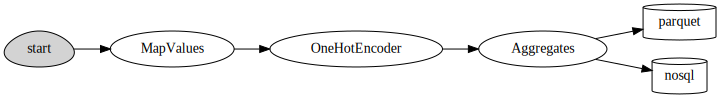

In [18]:
from mlrun.feature_store.steps import MapValues

# Define the `parties` FeatureSet
parties_set = fs.FeatureSet("parties", entities=[fs.Entity("source")], description="involved parties dataset")

# Extract the parties computation graph
parties_set_graph = parties_set.spec.graph

# Define and add the value mapping and one hot encoder mappings
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(data.gender.unique())}

# Add the value mapping and one hot encoding steps to the graph
parties_set_graph\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))

# Add the category aggregations
for category in main_categories:
    parties_set.add_aggregation(name=category,column=f'category_{category}', operations=['count'], windows=['14d'], period='1d')

# Add the default data targets
parties_set.set_targets()

# Plot the featuer set to inspect the different steps
parties_set.plot(rankdir="LR", with_targets=True)

After defining the `parties` feature set lets ingest the data and verify we created all the expected features

In [19]:
parties_df=fs.ingest(parties_set, data)
parties_df.columns

Index(['es_transportation_count_14d', 'es_health_count_14d',
       'es_otherservices_count_14d', 'es_food_count_14d',
       'es_hotelservices_count_14d', 'es_barsandrestaurants_count_14d',
       'es_tech_count_14d', 'es_sportsandtoys_count_14d',
       'es_wellnessandbeauty_count_14d', 'es_hyper_count_14d',
       'es_fashion_count_14d', 'es_home_count_14d', 'es_contents_count_14d',
       'es_travel_count_14d', 'es_leisure_count_14d', 'age_mapped', 'step',
       'age', 'gender_F', 'gender_M', 'gender_E', 'gender_U', 'zipcodeOri',
       'zipMerchant', 'category_es_transportation', 'category_es_health',
       'category_es_otherservices', 'category_es_food',
       'category_es_hotelservices', 'category_es_barsandrestaurants',
       'category_es_tech', 'category_es_sportsandtoys',
       'category_es_wellnessandbeauty', 'category_es_hyper',
       'category_es_fashion', 'category_es_home', 'category_es_contents',
       'category_es_travel', 'category_es_leisure', 'amount', 'fraud

### Deploy the Parties Feature set Ingestion Endpoint

In [20]:
# Deploy the parties feature set's ingestion service using the feature set
# and all the defined resources above.
# (*Since our source and function definitions are the same we can simply reuse them)
parties_set_endpoint = fs.deploy_ingestion_service(featureset=parties_set,
                                                   source=http_source,
                                                   run_config=run_config)

> 2021-06-20 13:13:23,784 [info] Starting remote function deploy
2021-06-20 13:13:23  (info) Deploying function
{'level': 'info', 'message': 'Deploying function', 'name': 'fraud-demo-orz-ingest-transactions', 'time': 1624194803864.9705}
2021-06-20 13:13:23  (info) Building
{'level': 'info', 'message': 'Building', 'name': 'fraud-demo-orz-ingest-transactions', 'time': 1624194803865.0024, 'versionInfo': 'Label: 1.5.16, Git commit: ae43a6a560c2bec42d7ccfdf6e8e11a1e3cc3774, OS: linux, Arch: amd64, Go version: go1.14.3'}
2021-06-20 13:13:24  (info) Staging files and preparing base images
{'level': 'info', 'message': 'Staging files and preparing base images', 'name': 'deployer', 'time': 1624194804370.6948}
2021-06-20 13:13:24  (info) Building processor image
{'imageName': 'nuclio/fraud-demo-orz-fraud-demo-orz-ingest-transactions-processor:latest', 'level': 'info', 'message': 'Building processor image', 'name': 'deployer', 'time': 1624194804371.5261}
2021-06-20 13:13:25  (info) Build complete


### Test the live ingestion endpoint

Now that our parties feature set endpoint is live we can easily test it by sending a sample from our dataset for live ingestion. If we've done everything well we should receive the ingestion `event id` back.

In [21]:
# Select a sample from the dataset and serialize it to JSON
sample = data.sample(1)
sample = json.loads(sample.to_json(orient='records'))[0]
sample['timestamp'] = '2021-06-11 22:07:58'
sample

{'step': 17,
 'age': '1',
 'gender': 'M',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 18.87,
 'fraud': 0,
 'timestamp': '2021-06-11 22:07:58',
 'source': 'C564489242',
 'target': 'M348934600',
 'device': 'b745e499ec434e13828e54517a6acba6'}

In [22]:
# Post the sample to the ingestion endpoint
requests.post(parties_set_endpoint, json=sample).text

'{"id": "0bf1fbc2-cff1-4bc2-b19c-c893ae6c6407"}'

### Create a labels dataset for model training

This feature set contains the label for the fraud demo, it will be ingested directly to the default targets without any changes

In [23]:
# Extract the labels from the available data
labels = data[['fraud','source','timestamp']].copy()
labels = labels.rename(columns={"fraud": "label"})
labels['label'] = labels['label'].astype(int)

# We save the data as a CSV to show how you can
# easily ingest or infer the data's metadata
# directly from the file
labels_filepath = os.path.join(data_path, 'labels.csv')
labels.to_csv(labels_filepath)

# Define the `labels` feature set
labels_set = fs.FeatureSet("labels", 
                           entities=[fs.Entity("source")], 
                           timestamp_key='timestamp',
                           description="training labels")

# Add the default save targets
labels_set.set_targets()

# Infer the feature set's metadata directly
# from the saved CSV file
df = fs.infer(labels_set, labels_filepath)

In [24]:
# Ingest the labels feature set
df = fs.ingest(labels_set, labels)
df.head()

,label,timestamp
source,,
C1692967183,0,2021-06-20 05:39:53.747545060
C1971153898,0,2021-06-19 19:18:35.512191783
C85142763,0,2021-06-18 21:55:08.332585748
C2014169866,0,2021-06-20 12:43:25.312538615
C1846578588,0,2021-06-18 22:38:20.288612236
